In [18]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import signal, sparse
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch import einsum

# Loading CPU-Net and support functions
from tools import (calc_current_amplitude, process_all_waveforms, calculate_tn, check_peak_alignment,
                   get_tail_slope, inf_train_gen, LambdaLR, weights_init_normal, select_quantile, calculate_iou)
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)
torch.cuda.empty_cache()
home_dir='/global/homes/k/kbhimani/'
eng_peak = 'dep'
eng_peak_load ='dep'

Running on cuda:0


In [2]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print whether CUDA is available or not
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA device count and device name(s)
if cuda_available:
    print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA Devices: 4
CUDA Device 0: NVIDIA A100-SXM4-40GB
CUDA Device 1: NVIDIA A100-SXM4-40GB
CUDA Device 2: NVIDIA A100-SXM4-40GB
CUDA Device 3: NVIDIA A100-SXM4-40GB


In [3]:
BATCH_SIZE = 16 # batch size, each batch is drawn from the infinite train generator
baseline_weight=1.0 # weight given to baseline portion of the waveform in loss function
ris_edge_weight=7.0 # weight giveing to rising edge of the waveform in loss function
tail_weight=9.0 # weight giving to the RC decay tail of the wavefrom in loss function
ITERS = 5000 # max number of interations to run
DECAY = 4000 # iteration at which learning rate starts to decay
LRATE_Gen =1e-3 # learning rate of the generator
LRATE_Disc =1e-3 # learning rate of the discriminator
cyc_loss_weight = 8 # weight of the cycle consistent loss in training, eg loss(sim->data->sim)
iden_loss_weight = 1 # weight of idenentity loss, for example ATN(data)- data
gan_loss_weight = 5 # weight of the generator loss. ATN(sim) - data
# bin_check_iter = 13200 # iteration at which we start checking with validation dataset
# bin_thres = 0 # toletance of matchig peaks of current amplitudes in validation, 0 means that peaks have to allign perfectly
# valid_check_iter = 1 # how often to check if the training and validation peaks allign, 1 means evaluation occurs at every training iteration

In [4]:
# det_pulses=home_dir+'CPU-Net/training_data/valid_transfromed.pkl'
# sim_pulses=home_dir+'CPU-Net/training_data/valid_sim.pkl'
sim_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_valid_transfromed.pkl'
det_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_cleaned.pickle'

dict_keys(['tp0', 'wf', 'event', 'energy'])


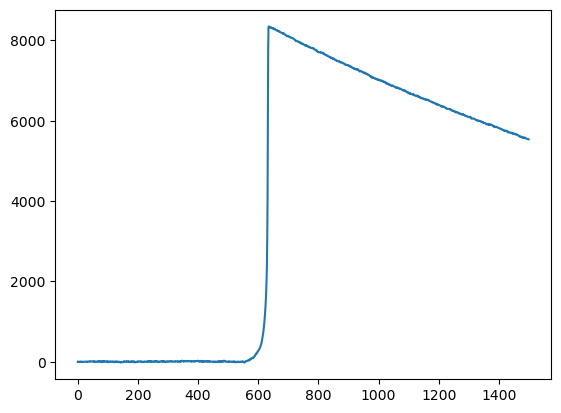

In [5]:
# An example of how to load the waveforms from pickle file
import pickle

with open(sim_pulses, "rb") as openfile:
    while True:
        try:
            wdict = pickle.load(openfile, encoding='latin1')
            print(wdict.keys())  # Add this line to debug
            test_wf = wdict["wf"]
            # Process wf as needed here
        except EOFError:
            break  # Exit the loop when end of file is reached
        except KeyError:
            print("Key 'wf' not found in dictionary.")
            continue  # Continue to the next iteration if 'wf' key is missing
        # You can add more except blocks as needed for handling other exceptions
        break
plt.plot(test_wf)

In [6]:
import numpy as np
import torch.utils.data as data_utils
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tools import calculate_tn
from tqdm import tqdm
import random
from scipy.optimize import curve_fit

'''
Parameters for training waveform construction.
LSPAN: how many sample to select to the left of time point 0 (start of the rise)
RSPAN: how many sample to select to the right of time point 0 (start of the rise)
SEQ_LEN: total length of the input pulses, always equal to LSPAN+RSPAN
'''
LSPAN=400
RSPAN=400
SEQ_LEN=LSPAN+RSPAN
t_n = 99
base_thres = 0.005 # mean of first 50 smaples should be less than this value
tail_thres = 0.80 # last 50 samples should be greater than this value
# chi_squared_threshold= 0.002
# popt_threshold = -2.6e-4
class SplinterDataset(Dataset):
    '''
    Splinter is the name of our local Ge detector
    '''
    def __init__(self, event_dset="DetectorPulses.pickle", siggen_dset="SimulatedPulses.pickle", n_max = 1e5, chi_squared_threshold=1, popt_threshold_under=-2, popt_threshold_over=2):
        self.n_max = n_max
        self.event_dict = []
        self.siggen_dict = []
        self.read_data_oto(event_dset, siggen_dset)
        print("Number of Data events:", len(self.event_dict))
        print("Number of Simulations events", len(self.siggen_dict))
        # Set the class attributes for thresholds here
        self.size = len(self.event_dict)
        self.sim_size = len(self.siggen_dict)
        self.event_ids = [wdict["event"] for wdict in self.siggen_dict]  # Adjust based on your data structure
        self.plot_waveform(np.random.randint(self.size)) 
        
    def __len__(self):
        # Return the minimum size between event_dict and siggen_dict to avoid out-of-range errors
        return min(len(self.event_dict), len(self.siggen_dict))

    def __getitem__(self, idx):
        # Use a single simulated waveform based on the index and transform it
        siggenwf = self.transform(self.siggen_dict[idx]["wf"], self.siggen_dict[idx]["tp0"])
        # Transform the real waveform for comparison or any other purpose
        real_wf = self.transform(self.event_dict[idx]["wf"], self.event_dict[idx]["tp0"])
        # Return the real waveform, the single transformed simulated waveform, and the original waveform
        event_id = self.siggen_dict[idx].get("event", -1)  # Default to -1 or suitable value if not found
        # Return the event_id as part of the output
        return real_wf[None, :], siggenwf[None, :], self.event_dict[idx]["wf"][None, :SEQ_LEN], event_id
        
    def return_label(self):
        return self.trainY
    
    def set_raw_waveform(self,raw_wf):
        self.raw_waveform = raw_wf

    def get_original_waveform(self,wf, input=False):
        if input:
            return self.input_transform.recon_waveform(wf)
        else:
            return self.output_transform.recon_waveform(wf)
    

    def normalize_waveform(self, wf):
        """Normalize waveform to have values between 0 and 1."""
        min_val = np.min(wf)
        max_val = np.max(wf)
        if max_val > min_val:
            return (wf - min_val) / (max_val - min_val)
        else:
            # Handle the case where max_val equals min_val (e.g., constant waveforms)
            return np.zeros_like(wf)  # or wf * 0 to return a waveform of zeros

    def transform(self, wf, tp0):
        """Transform waveform by padding based on tp0 and then normalizing."""
        wf = np.array(wf)
        # Ensure tp0 is an integer
        tp0 = int(round(tp0))
        left_padding = max(LSPAN - tp0, 0)
        right_padding = max((RSPAN + tp0) - len(wf), 0)
        # Apply padding
        wf_padded = np.pad(wf, (left_padding, right_padding), mode='edge')
        # Adjust tp0 after padding
        tp0_adjusted = tp0 + left_padding
        # Slice the waveform around the adjusted tp0 to ensure consistent length
        wf_sliced = wf_padded[(tp0_adjusted - LSPAN):(tp0_adjusted + RSPAN)]
        # Normalize the waveform after padding and slicing
        wf_normalized = self.normalize_waveform(wf_sliced)
        return wf_normalized

    def read_data_oto(self, event_dset, siggen_dset):
        event_list = []
        siggen_list = []
        with open(event_dset, "rb") as event_file, open(siggen_dset, "rb") as siggen_file:
            try:
                while True:
                    event_wdict = pickle.load(event_file)
                    siggen_wdict = pickle.load(siggen_file)
                    if "dc_label" in event_wdict and event_wdict["dc_label"] != 0.0:
                        continue
                    if "dc_label" in siggen_wdict and siggen_wdict["dc_label"] != 0.0:
                        continue
                    try:
                        event_tp0 = calculate_tn(event_wdict["wf"], t_n)
                        siggen_tp0 = calculate_tn(siggen_wdict["wf"], t_n)
                        event_wdict["tp0"] = event_tp0
                        siggen_wdict["tp0"] = siggen_tp0
                        # plt.plot(event_wdict["wf"])
                        # plt.axvline(event_tp0)
                        # plt.plot(siggen_wdict["wf"])
                        # plt.axvline(siggen_tp0)
                        transformed_event_wf = self.transform(event_wdict["wf"], event_tp0)
                        transformed_siggen_wf = self.transform(siggen_wdict["wf"], siggen_tp0)
                        # print(transformed_event_wf)
                        # plt.plot(transformed_event_wf)
                        if len(transformed_event_wf) == SEQ_LEN and len(transformed_siggen_wf) == SEQ_LEN:
                            event_list.append(event_wdict)
                            siggen_list.append(siggen_wdict)

                    except Exception as e:
                        # print("Exception", e)
                        continue  # Handle cases where tp0 calculation fails or transformation fails

            except EOFError:
                pass  # End of file reached

        self.event_dict = event_list
        self.siggen_dict = siggen_list
        if len(self.event_dict) != len(self.siggen_dict):
            raise ValueError("Mismatch in number of valid waveforms in event and simulation datasets.")

        print(f"Loaded {len(self.event_dict)} matched waveform pairs.")

    def validate_waveform(self, wf):
        """Validate the waveform against certain thresholds and conditions."""
        mean_first_250 = np.mean(wf[:250])
        mean_last_50 = np.mean(wf[-50:])
        if any(wf[:250] > 0.01) or mean_first_250 > base_thres or any(wf[-50:] < tail_thres) or mean_last_50 < 0.80:
            return False  # Waveform does not meet the criteria
        chi_squared, popt = self.process_wf_log_linear(wf)
        return chi_squared < self.chi_squared_threshold and self.popt_threshold_under < popt < self.popt_threshold_over
    
    def get_field_from_dict(self, input_dict, fieldname):
        field_list = []
        for event in input_dict:
            field_list.append(event[fieldname])
        return field_list
    
    def get_current_amp(self,wf):
        return max(np.diff(wf.flatten()))
    
    def plot_waveform(self, idx):
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # Create a figure with two subplots side by side

        # Plotting 100 Random Pulses
        for i in range(100):
            waveform, waveform_deconv, rawwf, _ = self.__getitem__(i)
            axs[0].plot(waveform[0], linewidth=0.5)
        axs[0].set_title("100 Random Data Pulses")
        axs[0].set_xlabel("Time Sample [ns]")
        axs[0].set_ylabel("Normalized Pulses")
        axs[0].grid(True, linestyle='--', linewidth=0.5)

        # Plotting 100 Simulated WF
        for i in range(100):
            waveform, waveform_deconv, rawwf, _ = self.__getitem__(i)
            axs[1].plot(waveform_deconv[0], linewidth=0.5)
        axs[1].set_title("100 Random Simulated Pulses")
        axs[1].set_xlabel("Time Sample [ns]")
        axs[1].set_ylabel("Normalized Pulses")
        axs[1].grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()  
        plt.savefig('figs/inputs.png')
    
    def linear(self, x, a, b):
        """Linear function ax + b"""
        return a * x + b
    
    def process_wf_log_linear(self, wf):
        sample = 300
        if len(wf) < sample:
            # Return default values if waveform is too short
            return np.nan, [np.nan, np.nan]  # Ensure popt is a list or array to safely index [0] later
        x_data = np.arange(sample)
        y_data = np.log(np.clip(wf[-sample:], 1e-10, None))  # Log of last 300 samples
        try:
            popt, pcov = curve_fit(self.linear, x_data, y_data, maxfev=100000)
            # Calculate residuals and chi-squared for goodness of fit
            residuals = y_data - self.linear(x_data, *popt)
            chi_squared = np.sum((residuals ** 2) / self.linear(x_data, *popt))
        except Exception as e:
            # Handle fitting errors
            popt = [np.nan, np.nan]  # Ensure popt is a list or array
            chi_squared = np.nan
        return -chi_squared, popt[0] #chi squared would be negative since log of number between 0,1 is negavtive, so we return positive value  

Loaded 2989 matched waveform pairs.
Number of Data events: 2989
Number of Simulations events 2989


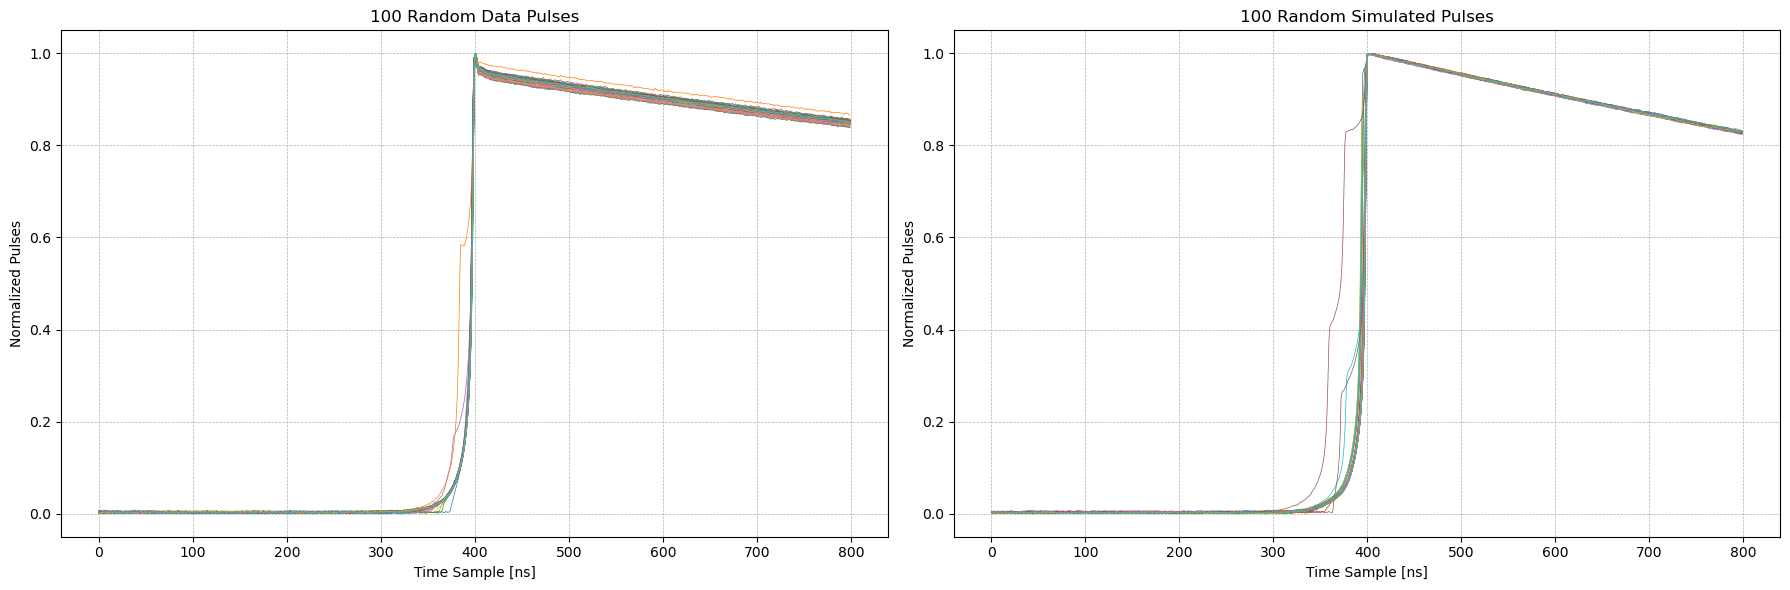

In [7]:
# Load the dataset
dataset = SplinterDataset(det_pulses, sim_pulses, chi_squared_threshold=100, popt_threshold_under=-10, popt_threshold_over=10)

# Define the proportion of the dataset to include in the validation split
validation_split = 0.2
shuffle_dataset = True
random_seed = 42222

# Create indices for the split
indices = np.arange(len(dataset))
split = int(np.floor(validation_split * len(dataset)))

# Set the random seed for reproducibility
if shuffle_dataset:
    np.random.seed(random_seed)
    # Shuffle only the training part of the dataset
    training_indices = indices[split:]
    np.random.shuffle(training_indices)
    indices[split:] = training_indices  # Place shuffled training indices back

# Now split into train and validation indices
train_indices, val_indices = indices[split:], indices[:split]

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Set the dataset to use raw waveform or not
dataset.set_raw_waveform(False)

# Define the DataLoader for training and validation sets
train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, drop_last=True)

# For infinite training generator
data = inf_train_gen(train_loader)

In [8]:
class WFDist(nn.Module):
    '''
    Waveform Distance, this is a special type of L1 loss which gives more weight to the
    rising and falling edge of each pulse
    baseline(0,250) rising edge=(250,500), tail=(500,800)

    '''
    def __init__(self, baseline_weight, ris_edge_weight, tail_weight):
        super(WFDist, self).__init__()
        self.criterion = nn.L1Loss()
        self.weight = torch.tensor([baseline_weight]*250+[ris_edge_weight]*150+[tail_weight]*(400)).to(DEVICE)
        # self.weight = torch.tensor([3.0]*250+[8.0]*250+[6.0]*(300)).to(DEVICE) #latest to work

    def forward(self, x1, x2):
        loss_out = 0.0
        for i in range(x1.size(0)):
            loss_out += self.criterion(x1[i].view(-1)*self.weight, x2[i].view(-1)*self.weight)#/self.weight.sum()
        return loss_out/x1.size(0)

In [9]:
target_real = torch.ones(BATCH_SIZE,1).to(DEVICE) #tensor to hold 
target_fake = torch.zeros(BATCH_SIZE,1).to(DEVICE)
netG_A2B = PositionalUNet() # Generator from Data to Simulations (ATN)
netG_B2A = PositionalUNet() # Generator from Simulations to Data (IATN)
netD_A = RNN().apply(weights_init_normal) # Discriminator whose job is to verigy is a pulse looks like data
netD_B = RNN().apply(weights_init_normal) # Discriminator whose job is to verigy is a pulse looks like simulations
netG_A2B.to(DEVICE)
netG_B2A.to(DEVICE)
netD_A.to(DEVICE)
netD_B.to(DEVICE)

criterion_GAN = nn.BCELoss().to(DEVICE)
criterion_cycle = WFDist(baseline_weight, ris_edge_weight, tail_weight).to(DEVICE)
criterion_identity = WFDist(baseline_weight, ris_edge_weight, tail_weight).to(DEVICE)

optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=LRATE_Gen, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=LRATE_Disc, betas=(0.5, 0.999))


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(ITERS, 0, DECAY).step)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters in netG_A2B: {count_parameters(netG_A2B)}")
print(f"Total trainable parameters in netG_B2A: {count_parameters(netG_B2A)}")
print(f"Total trainable parameters in netD_A: {count_parameters(netD_A)}")
print(f"Total trainable parameters in netD_B: {count_parameters(netD_B)}")

Total trainable parameters in netG_A2B: 7213781
Total trainable parameters in netG_B2A: 7213781
Total trainable parameters in netD_A: 130817
Total trainable parameters in netD_B: 130817


In [10]:
# Initialize lists to store loss values
losses_G = []
losses_D_A = []
losses_D_B = []
losses_GAN_A2B =[]
losses_GAN_B2A =[]
losses_identity_A = []
losses_identity_B = []
losses_cycle_ABA = []
losses_cycle_BAB = []
learning_rates_G = []
 
for iteration in tqdm(range(ITERS)):
    netG_A2B.train()
    netG_B2A.train()

    #########################
    # A: det_pulsesrPulses
    # B: Simulated Pulses
    #########################
    
    real_A, real_B = next(data)
    real_A = real_A.to(DEVICE).float()
    real_B = real_B.to(DEVICE).float()

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # Identity loss
    # G_A2B(B) should equal B if real B is fed
    same_B = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B, real_B)*iden_loss_weight
    # G_B2A(A) should equal A if real A is fed
    same_A = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A, real_A)*iden_loss_weight

    # GAN loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    # loss_GAN_A2B = pred_fake.mean()
    # loss_GAN_A2B.backward(target_real)
    
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real)*gan_loss_weight

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    # loss_GAN_B2A = pred_fake.mean()
    # rand = torch.tensor(np.random.rand()).to(DEVICE)*0.5+0.5
    # random_real = random_real[torch.randperm(random_real.size(0))]
    loss_GAN_B2A = criterion_GAN(pred_fake,target_real)*gan_loss_weight

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*cyc_loss_weight

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*cyc_loss_weight

    # Total loss
    loss_G = loss_identity_A + loss_identity_B + loss_cycle_ABA + loss_cycle_BAB + loss_GAN_A2B + loss_GAN_B2A
    loss_G.backward()

    optimizer_G.step()
    ###### Discriminator A (Detector Pulses) ######
    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)


    # Total loss
    loss_D_A = loss_D_real + loss_D_fake
    loss_D_A.backward()

    optimizer_D_A.step()
    ###### Discriminator B (Simulated Pulses) ######
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_B = loss_D_real + loss_D_fake
    loss_D_B.backward()
    optimizer_D_B.step()

    current_lr_G = lr_scheduler_G.get_last_lr()[0]
    # Append each loss to its corresponding list
    losses_G.append(loss_G.item())
    losses_D_A.append(loss_D_A.item())
    losses_D_B.append(loss_D_B.item())
    losses_GAN_A2B.append(loss_GAN_A2B.item())
    losses_GAN_B2A.append(loss_GAN_B2A.item())
    losses_identity_A.append(loss_identity_A.item())
    losses_identity_B.append(loss_identity_B.item())
    losses_cycle_ABA.append(loss_cycle_ABA.item())
    losses_cycle_BAB.append(loss_cycle_BAB.item())
    learning_rates_G.append(current_lr_G)

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()  
torch.save(netG_B2A.state_dict(), f'model_weights/valid_ATN.pt')
torch.save(netG_A2B.state_dict(), f'model_weights/valid_IATN.pt')  
torch.save(netD_A.state_dict(), f'model_weights/valid_netD_A.pth')
torch.save(netD_B.state_dict(), f'model_weights/valid_netD_B.pth')

100%|██████████| 5000/5000 [19:28<00:00,  4.28it/s]


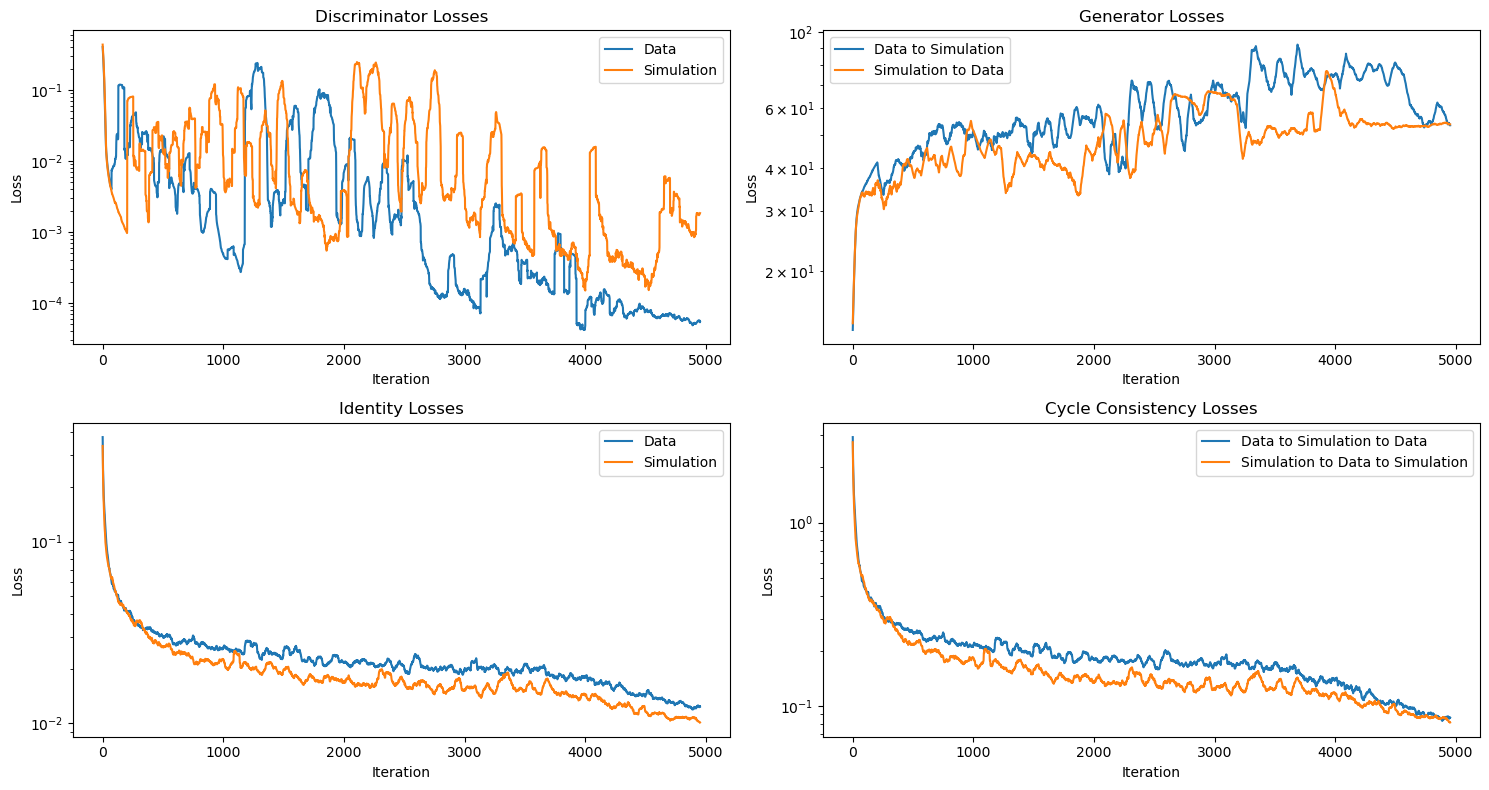

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
win=50 

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
# plt.plot(moving_average(losses_G, win), label='Total Generator Loss')
plt.plot(moving_average(losses_D_A, win), label='Data')
plt.plot(moving_average(losses_D_B, win), label='Simulation')
plt.title('Discriminator Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(moving_average(losses_GAN_A2B, win), label='Data to Simulation')
plt.plot(moving_average(losses_GAN_B2A, win), label='Simulation to Data')
plt.title('Generator Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(moving_average(losses_identity_A, win), label='Data')
plt.plot(moving_average(losses_identity_B, win), label='Simulation')
plt.title('Identity Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moving_average(losses_cycle_ABA, win), label='Data to Simulation to Data')
plt.plot(moving_average(losses_cycle_BAB, win), label='Simulation to Data to Simulation')
plt.title('Cycle Consistency Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig('figs/loss_funcs.png')

In [12]:
ATN = PositionalUNet()
ATN.to(DEVICE)
pretrained_dict = torch.load('model_weights/valid_ATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')
model_dict = ATN.state_dict()
model_dict.update(pretrained_dict) 
ATN.load_state_dict(pretrained_dict)
ATN.eval()

IATN = PositionalUNet()
IATN.to(DEVICE)
pretrained_dict_inv = torch.load('model_weights/valid_IATN.pt')
# pretrained_dict = torch.load('fep_training/ATN_epoch_1.pt')

model_dict_inv = IATN.state_dict()
model_dict_inv.update(pretrained_dict_inv) 
IATN.load_state_dict(pretrained_dict_inv)
IATN.eval()

PositionalUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 40, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv1d(40, 40, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(40, 80, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
          (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv1d(80, 

In [13]:
wf, wf_deconv, a,b = next(iter(test_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = ATN(wf_deconv)
outputs_inv = IATN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()

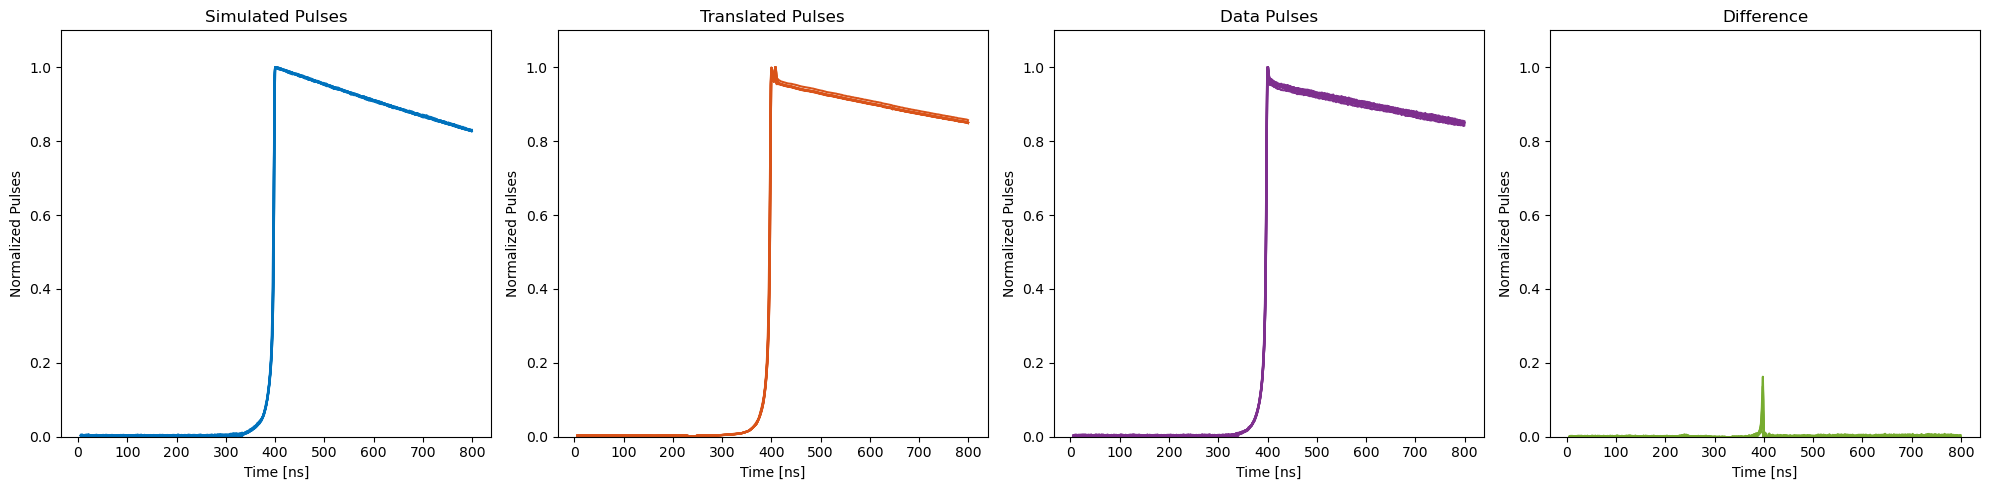

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cycle_BAB_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", eng_peak_load="eng_peak_load"):
    # Initialize lists to store waveforms
    real_Bs, fake_As, recovered_Bs, real_As, differences = [], [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 5  

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, a, b = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate and recover
        with torch.no_grad():
            fake_A = netG_B2A(real_B)
            recovered_B = netG_A2B(fake_A)

        # Collect waveforms
        real_Bs.append(real_B[0, 0, :].cpu().numpy())
        fake_As.append(fake_A[0, 0, :].cpu().numpy())
        recovered_Bs.append(recovered_B[0, 0, :].cpu().numpy())
        real_As.append(real_A[0, 0, :].cpu().numpy())
        differences.append(real_As[-1] - fake_As[-1])

    # Plotting
    colors = {
        "real_B": "#0072BD",  # bright blue
        "fake_A": "#D95319",  # bright orange
        "recovered_B": "#7E2F8E",  # purple
        "difference": "#77AC30"  # green
    }

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  
    titles = ["Simulated Pulses", "Translated Pulses", "Data Pulses", "Difference"]
    waveform_lists = [real_Bs, fake_As, real_As, differences]
    color_keys = ["real_B", "fake_A", "recovered_B", "difference"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_ylim([0,1.1])
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normalized Pulses')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x4_cycle_BAB.png")
    plt.show()

# Example usage
plot_cycle_BAB_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10, eng_peak="SEP", eng_peak_load="DEP")


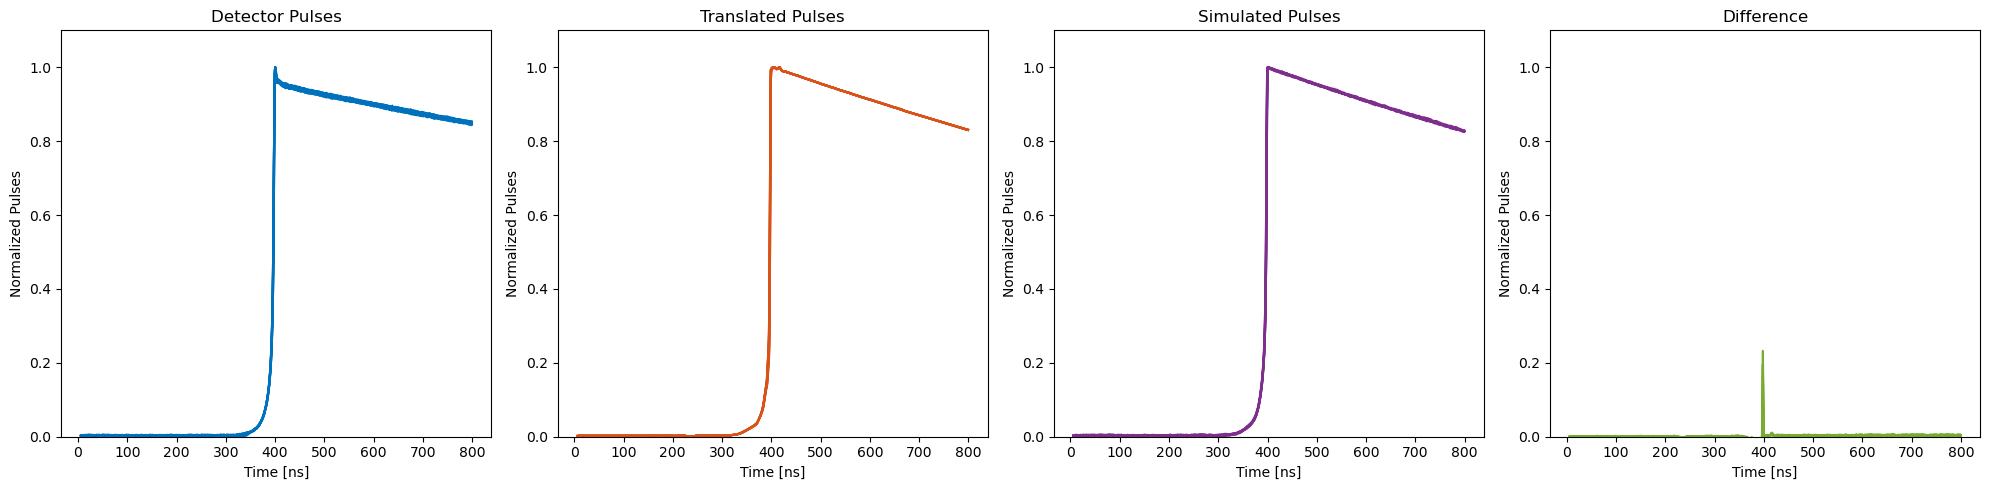

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cycle_ABA_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5):
    # Initialize lists to store waveforms
    real_As, fake_Bs, real_Bs, differences = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = time > 5  

    # Loop over a fixed number of samples
    for _ in range(sample_rate):
        real_A, real_B, _, _ = next(iter(train_loader))
        real_A = real_A.to(DEVICE)
        real_B = real_B.to(DEVICE)

        # Generate
        with torch.no_grad():
            fake_B = netG_A2B(real_A)

        # Collect waveforms
        real_As.append(real_A[0, 0, :].cpu().numpy())
        fake_Bs.append(fake_B[0, 0, :].cpu().numpy())
        real_Bs.append(real_B[0, 0, :].cpu().numpy())
        differences.append((fake_B - real_B)[0, 0, :].cpu().numpy())

    # Plotting
    colors = {
        "real_A": "#0072BD",  # bright blue
        "fake_B": "#D95319",  # bright orange
        "real_B": "#7E2F8E",  # purple
        "difference": "#77AC30"  # green
    }

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Detector Pulses", "Translated Pulses", "Simulated Pulses", "Difference"]
    waveform_lists = [real_As, fake_Bs, real_Bs, differences]
    color_keys = ["real_A", "fake_B", "real_B", "difference"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut], waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_ylim([0,1.1])
        ax.set_title(title)
        ax.set_xlabel('Time [ns]')
        ax.set_ylabel('Normalized Pulses')
        if i == 0:
            ax.legend(loc='upper right')

    fig.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.savefig("figs/result_comp_1x4_cycle_ABA.png")
    plt.show()

# Example usage, assuming netG_A2B, train_loader, DEVICE have been defined appropriately
plot_cycle_ABA_with_style(IATN, ATN, train_loader, DEVICE, sample_rate=10)


In [16]:
ts = []
gan_ts = []
ca = []
gan_ca = []
sim_ca = []
data_wf= []
siggen_wf= []

i=0
for wf, wf_deconv,rawwf,c in tqdm(train_loader):
    # if i==20: #processs only 10 batches
    #     break
    bsize = wf.size(0)
    gan_wf = ATN(wf_deconv.to(DEVICE).float())
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        ca.append(calc_current_amplitude(datawf))
        gan_ca.append(calc_current_amplitude(transfer_wf))
        sim_ca.append(calc_current_amplitude(siggenwf))
        siggen_wf.append(siggenwf)
        data_wf.append(datawf)
        
    #     plt.plot(datawf)
    #     plt.axvline(calculate_tp0(datawf, 0.002), color='b', alpha=0.5, label='tp_0')
    #     plt.axvline(calculate_tn(datawf, 99),color='r', alpha=0.5, label='tp_99')
    #     plt.legend()
    #     plt.show()
    #     plt.plot(siggenwf)
    #     plt.axvline(calculate_tp0(siggenwf,0.002), color='b', alpha=0.5, label='tp_0')
    #     plt.axvline(calculate_tn(siggenwf,99),color='r', alpha=0.5, label='tp_99')
    #     plt.legend()
    #     break
    # break
    i += 1

100%|██████████| 149/149 [00:05<00:00, 26.04it/s]


IoU: 52.4396070725


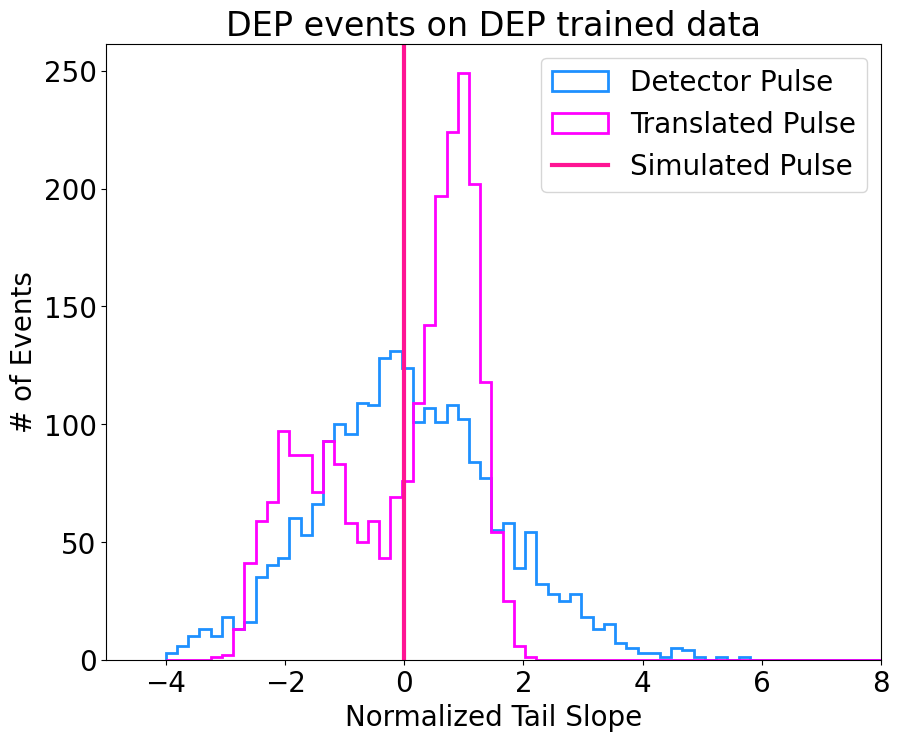

In [19]:
# Check if data is not empty after filtering and selection
if len(ts) > 0 and len(gan_ts) > 0:
    ts_quantile = select_quantile(ts)
    gan_ts_quantile = select_quantile(gan_ts)
    # Ensure selected quantile data is not empty before proceeding
    if len(ts_quantile) > 0 and len(gan_ts_quantile) > 0:
        plt.rcParams['font.size'] = 20
        plt.rcParams["figure.figsize"] = (10,8)
        mean_ts, std_ts = norm.fit(select_quantile(ts))
        ts_normalized = (np.array(ts) - mean_ts) / std_ts
        mean_gan_ts, std_gan_ts = norm.fit(select_quantile(gan_ts))
        gan_ts_normalized = (np.array(gan_ts) - mean_gan_ts) / std_gan_ts
        mean,std = norm.fit(select_quantile(ts))
        rg = np.linspace(-4,9,70)
        plt.hist(ts_normalized,bins=rg,histtype="step",linewidth=2,density=False,color="dodgerblue",label="Detector Pulse")
        plt.hist(gan_ts_normalized,bins=rg,histtype="step",linewidth=2,density=False,color="magenta",label="Translated Pulse")
        plt.axvline(x=0,color="deeppink",linewidth=3,label="Simulated Pulse")
        plt.xlim(-5,8)
        plt.legend()
        plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
        plt.ylabel("# of Events")
        plt.xlabel("Normalized Tail Slope")
        # plt.savefig("figs/tailslope.png",dpi=200)
        # Calculate the histograms (with density=True to normalize the histograms)
        hist_ts, _ = np.histogram(ts_normalized, bins=rg)
        hist_gan_ts, _ = np.histogram(gan_ts_normalized, bins=rg)
        # Calculate IoU for the two histograms
        iou = calculate_iou(ts_normalized, gan_ts_normalized, rg, normed=False)
        print(f"IoU: {iou:.10f}")
    else:
        print("Quantile selected data is empty or invalid.")
else:
    print("Data is empty or contains only NaN values after filtering.")


IoU between Detector Peak and Simulated Peak: 3.7551128631
IoU between Detector Peak and Translated Peak: 36.9179757120


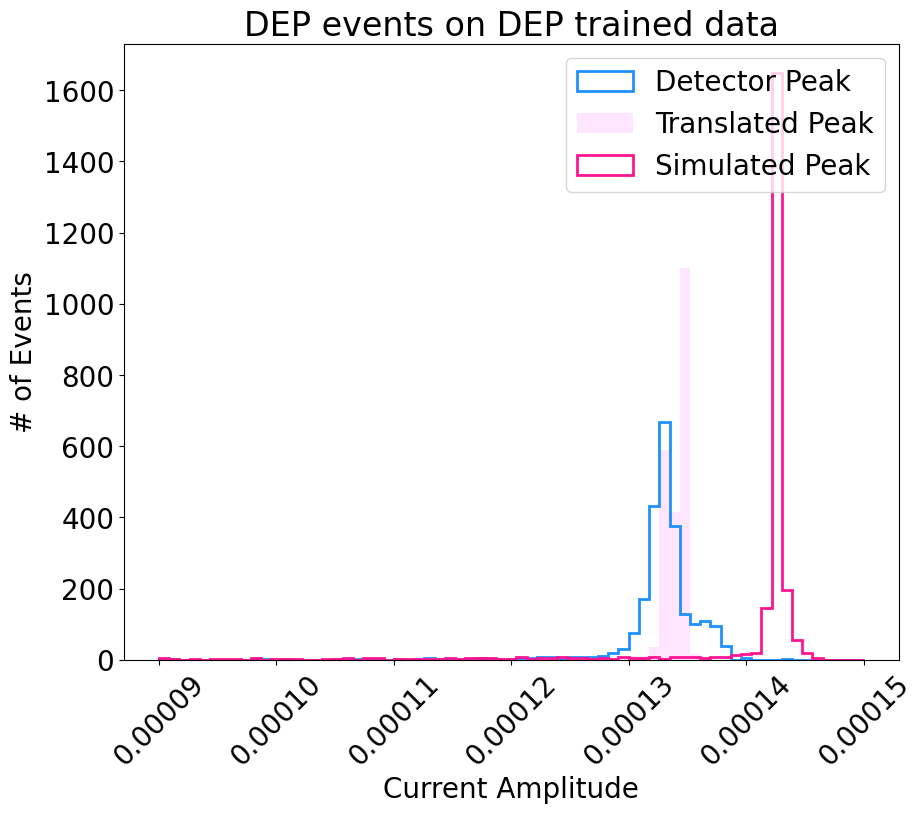

In [20]:
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"] = (10,8)
# rg = np.linspace(0.000125, 0.00015, 50)
rg = np.linspace(0.00009, 0.00015, 70)
# rg=200
plt.hist(ca,label="Detector Peak",bins=rg, histtype="step",linewidth=2,color="dodgerblue")
plt.hist(gan_ca,label="Translated Peak",bins=rg,alpha=0.1,color="magenta")
plt.hist(sim_ca,label="Simulated Peak",bins=rg,linewidth=2,histtype="step",color="deeppink")
plt.xlabel("Current Amplitude")
plt.xticks(rotation=45)
plt.ylabel("# of Events")
plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
plt.legend(loc="upper right")


print(f"IoU between Detector Peak and Simulated Peak: {calculate_iou(ca, sim_ca, rg, normed=False):.10f}")
print(f"IoU between Detector Peak and Translated Peak: {calculate_iou(ca, gan_ca, rg, normed=False):.10f}")

# plt.yscale("log")
# plt.savefig("figs/dep_current_amp.png",dpi=200)